# Set up

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import random

from scipy.stats import chi2_contingency
from scipy.stats import shapiro, ks_2samp, kstest
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import levene

In [2]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path 
import tarfile
import urllib.request  

from kaggle.api.kaggle_api_extended import KaggleApi

In [3]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

# Get Data

In [5]:
from kaggle.api.kaggle_api_extended import KaggleApi
#from kaggle.rest import ApiException  # pour catcher les erreurs HTTP Kaggle
import zipfile

api = KaggleApi()
api.authenticate()

def load_titanic_data_from_kaggle(local_dir: str = "datasets", 
                                 zip_name: str = "titanic.zip", name: str = "titanic") -> dict[str, pd.DataFrame]: 
    """
    Téléchage (si nécessaire), extrait et charger les données de la compétition kaggle titanic 
    
    """
    # Définition des chemins: 
    local_dir  = Path(local_dir)
    zip_path = local_dir / zip_name
    extract_path = local_dir / name

    # si le chemin de contient aucun fichier 
    if not zip_path.is_file(): 
        Path(local_dir).mkdir(parents=True, exist_ok=True)  # On crée un dossier, s'il n'existe pas 
        print("Creation of the folder")

        # Telechargement du fichier depuis kaggle 
        api.competition_download_files(name, path=local_dir)
        print("Download from the API")
        
    # Extraire & et Ouvrir les données 
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)    
        print (zip_ref.namelist())
        #datasets = {k: pd.read_csv(f"{extract_path}/{k}") for k in zip_ref.namelist()}                            
        return [pd.read_csv(f"{extract_path}/{file}") for file in zip_ref.namelist()]
    

In [6]:
gender_submission, test_set, train_set = load_titanic_data_from_kaggle("data","titanic.zip")

['gender_submission.csv', 'test.csv', 'train.csv']


# Exploratory Data Analysis

## Quick Overview

In [7]:
# General information 
print("Shape of the train set:", train_set.shape)
print("Shape of the test set:", test_set.shape)
print("Shape of gender_submission set:", gender_submission.shape)
ratio_test_train_set = test_set.shape[0]/(train_set.shape[0]+ test_set.shape[0])
print(f"The testset represent {round(ratio_test_train_set*100, 1)}% of the entire dataset")

Shape of the train set: (891, 12)
Shape of the test set: (418, 11)
Shape of gender_submission set: (418, 2)
The testset represent 31.9% of the entire dataset


In [8]:
train_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
gender_submission.head(3)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0


**Variable definitions**:
- **PassengerId**: unique identifier for each passenger
- **Survived**:  0 means that the passenger did not survive, while 1 means that he/she survived. This is what we will try to predict in this mini-project
- **Pclass**: passenger class.
- **Name**, **Sex**, **Age**: self-explanatory
- **SibSp**: number of siblings and spouses of the passenger on board the ship.
- **Parch**: number of children and parents of the passenger on board the ship.
- **Ticket**: ticket number
- **Fare**: price paid (in pounds sterling)
- **Cabin**: passenger's cabin number
- **Embarked**:  place of embarkation

In [10]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [11]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


- The are some missing value for 'age' and 'Embarked' columns, this can be fix by a imputation method 
- The 'Cabin' column has less than 30% of completeness, so I think i should not use it as an input of the model
- The 'PClass' is a categorical variable formated in int
- There is not target in the test_set from kaggle

In [12]:
gender_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB


In [13]:
def df_completeness(df): 
    """
    Calcul le pourcentage complétude de chaque colonne d'un dataframe 
    """
    total = df.shape[0]
    column_null_values = df.isna().sum()
    return round(100*(total - column_null_values)/total,1)

In [14]:
# Completeness percentage 
print("\t Completeness of df_train:\n", df_completeness(train_set))
print("\n\t Completeness of df_test:\n", df_completeness(test_set))

	 Completeness of df_train:
 PassengerId    100.0
Survived       100.0
Pclass         100.0
Name           100.0
Sex            100.0
Age             80.1
SibSp          100.0
Parch          100.0
Ticket         100.0
Fare           100.0
Cabin           22.9
Embarked        99.8
dtype: float64

	 Completeness of df_test:
 PassengerId    100.0
Pclass         100.0
Name           100.0
Sex            100.0
Age             79.4
SibSp          100.0
Parch          100.0
Ticket         100.0
Fare            99.8
Cabin           21.8
Embarked       100.0
dtype: float64


In [15]:
## Any duplicate ? 
print(train_set.duplicated().sum())
print(train_set.drop(columns ="PassengerId").duplicated().sum()) # Dataframe without the ID column

# Same for the test set 
print(test_set.duplicated().sum())
test_set.drop(columns ="PassengerId").duplicated().sum()

0
0
0


np.int64(0)

**Analysis of categorical and text columns**

In [16]:
## Distribution of the categorical variable 
print(train_set['Embarked'].value_counts(dropna=False))
print(train_set['Embarked'].value_counts(normalize=True, dropna=False).round(2))

Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64
Embarked
S      0.72
C      0.19
Q      0.09
NaN    0.00
Name: proportion, dtype: float64


In [17]:
object_col = [col_name for col_name in train_set.select_dtypes(include='object').columns]
nb_classes_list = []
for col in object_col: 
    print(f"\n ** {col.upper()} **")
    nb_classes = train_set[col].nunique()
    print(f"{col} has {nb_classes} differents values")
    print(train_set[col].value_counts(dropna=False))


 ** NAME **
Name has 891 differents values
Name
Dooley, Mr. Patrick                                    1
Braund, Mr. Owen Harris                                1
Cumings, Mrs. John Bradley (Florence Briggs Thayer)    1
Heikkinen, Miss. Laina                                 1
Futrelle, Mrs. Jacques Heath (Lily May Peel)           1
                                                      ..
Uruchurtu, Don. Manuel E                               1
Spencer, Mrs. William Augustus (Marie Eugenie)         1
Glynn, Miss. Mary Agatha                               1
Wheadon, Mr. Edward H                                  1
Meyer, Mr. Edgar Joseph                                1
Name: count, Length: 891, dtype: int64

 ** SEX **
Sex has 2 differents values
Sex
male      577
female    314
Name: count, dtype: int64

 ** TICKET **
Ticket has 681 differents values
Ticket
1601         7
CA. 2343     7
347082       7
3101295      6
CA 2144      6
            ..
A/5 21172    1
349219       1
234818      

- All 'Names' are unique, so this columns will be considerate as an id and not an input features for the model 
- Cabin is most of the time empty (less than 30%), but some row count many cabins.
- Embarked has 2 null values so we should use a imputation method

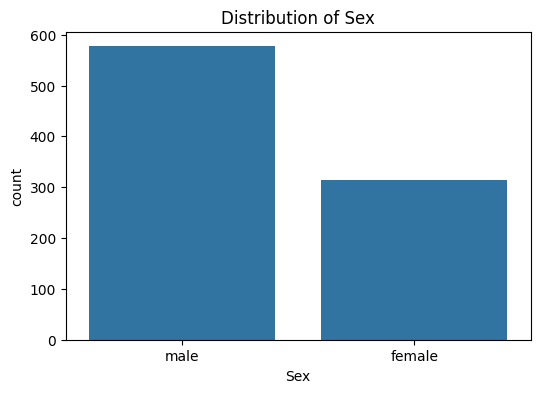

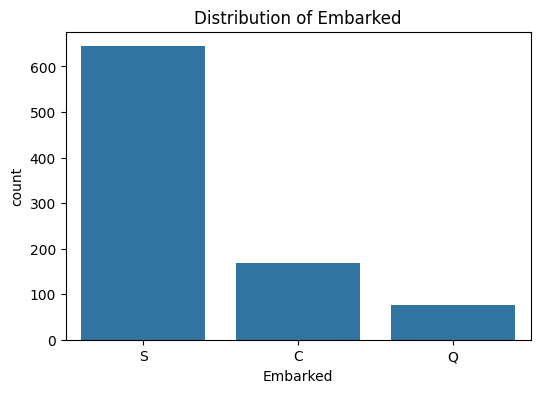

In [18]:
# Visualisation of categorical and text column 
for col in [col for col in object_col if train_set[col].nunique() < 10]:
    plt.figure(figsize=(6,4))
    sns.countplot(train_set, x=col)
    plt.title(f"Distribution of {col}")
    plt.show()

**First analysis of numerical column**

In [19]:
## Distribution of the numeric variables
train_set.describe(percentiles=[0.25,0.5,0.75,0.99]).round(2)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,891.00,714.00,891.00,891.00,891.00
mean,446.00,0.38,2.31,29.70,0.52,0.38,32.20
std,257.35,0.49,0.84,14.53,1.10,0.81,49.69
min,1.00,0.00,1.00,0.42,0.00,0.00,0.00
25%,223.50,0.00,2.00,20.12,0.00,0.00,7.91
50%,446.00,0.00,3.00,28.00,0.00,0.00,14.45
75%,668.50,1.00,3.00,38.00,1.00,0.00,31.00
99%,882.10,1.00,3.00,65.87,5.00,4.00,249.01
max,891.00,1.00,3.00,80.00,8.00,6.00,512.33


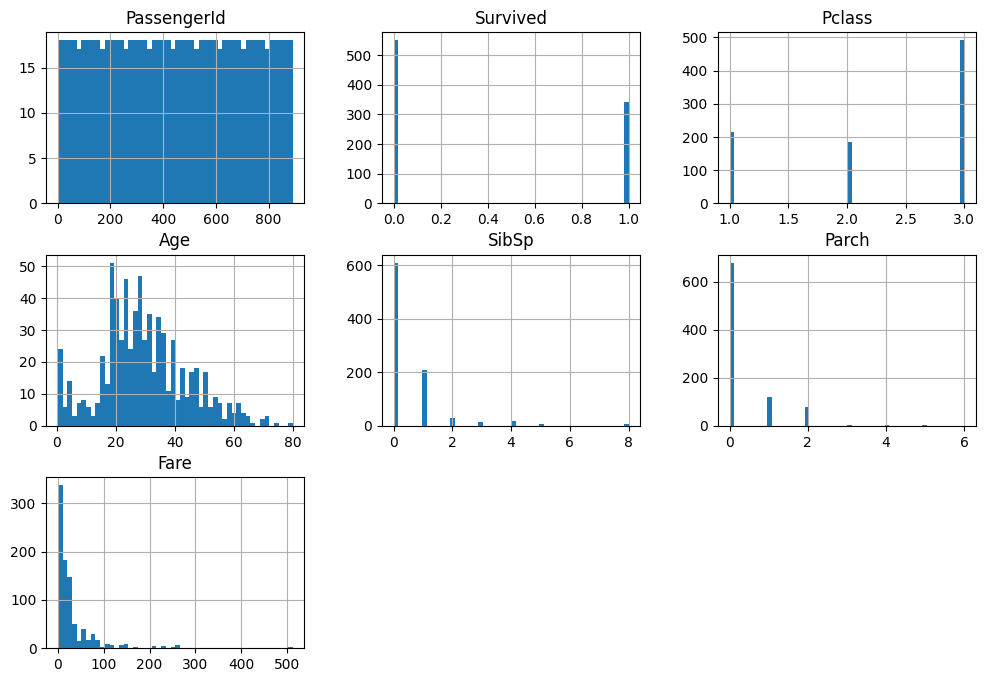

In [20]:
train_set.hist(bins=50, figsize=(12,8))
plt.show()

- There a fare at \$500 but the last highest fare is about 250, it's can be a outlier.
- The target is not well balanced

## Exploration of the train set

_**NB:**_ We will conduct the exploration only on the trainset,  in order to not be influence by the test set "pattern"

In [21]:
df_train = train_set.copy(deep=True)

**Analysis of the sex variable**

In [22]:
# Preprocessing for analysis 
from sklearn.preprocessing import OneHotEncoder
sex_encoder = OneHotEncoder(drop='first', sparse_output=False)

# Raw version df_sex 
print("Distribution - Before encoding")
print(df_train['Sex'].value_counts())

df_train['Sex']  = sex_encoder.fit_transform(df_train[['Sex']])

# See the transformation 
print("\nDistribution - After encoding")
print(df_train['Sex'].value_counts())

Distribution - Before encoding
Sex
male      577
female    314
Name: count, dtype: int64

Distribution - After encoding
Sex
1.0    577
0.0    314
Name: count, dtype: int64


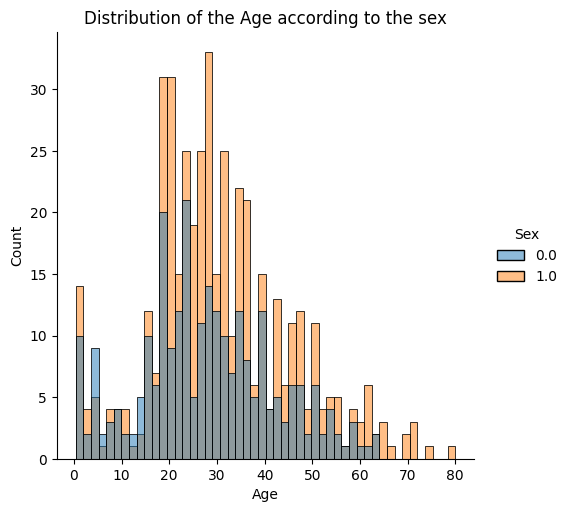

In [23]:
## Analysing the sex by age 
sns.displot(data=df_train, x="Age", hue="Sex", bins=50)
plt.title("Distribution of the Age according to the sex")
plt.show()

**Analysing the target**

In [24]:
print(df_train['Survived'].value_counts())
(df_train['Survived'].value_counts(normalize=True, dropna=False)*100).round(1)

Survived
0    549
1    342
Name: count, dtype: int64


Survived
0    61.6
1    38.4
Name: proportion, dtype: float64

- Only 40% of the passengers survived

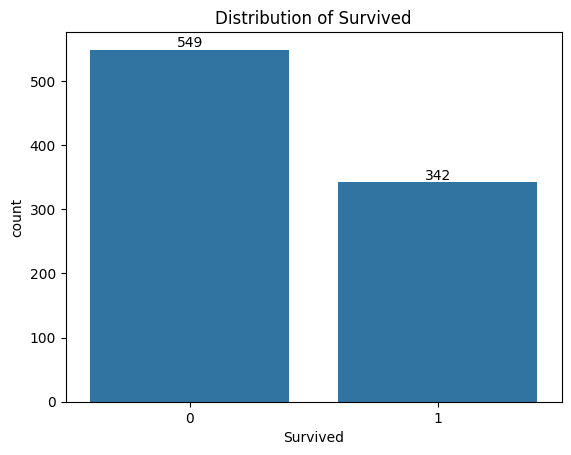

In [25]:
# Visualisation
ax = sns.barplot(df_train['Survived'].value_counts())
ax.bar_label(ax.containers[0], fontsize=10)
plt.title("Distribution of Survived")
plt.show()

**Fare, Plcass, Embarked & outlier Check**

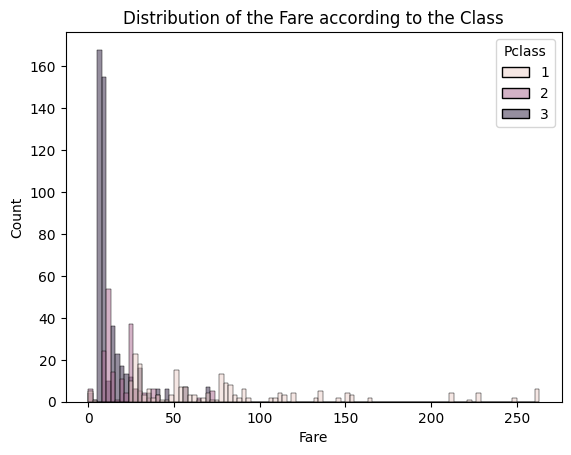

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,216.0,84.0,78.0,0.0,31.0,60.0,94.0,512.0
2,184.0,21.0,13.0,0.0,13.0,14.0,26.0,74.0
3,491.0,14.0,12.0,0.0,8.0,8.0,16.0,70.0


In [26]:
# Visualization of the Fare by Classe
df_viz = df_train[df_train["Fare"] < 300]
sns.histplot(data=df_viz, x='Fare', hue="Pclass", bins=100)
plt.title("Distribution of the Fare according to the Class")
plt.show()
# Distribution of the Fare by Classe
df_train.groupby(["Pclass"])["Fare"].describe().round()

- The mean price decreases based on the class. The 3rd class has the lower mean ticket price.

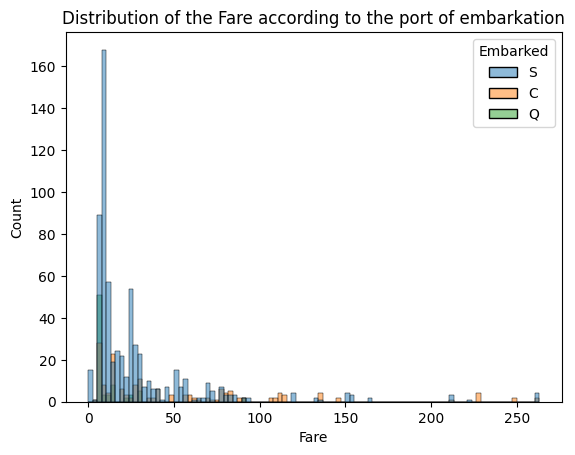

,count,mean,std,min,25%,50%,75%,max
Embarked,,,,,,,,
C,168.0,60.0,84.0,4.0,14.0,30.0,79.0,512.0
Q,77.0,13.0,14.0,7.0,8.0,8.0,16.0,90.0
S,644.0,27.0,36.0,0.0,8.0,13.0,28.0,263.0


In [27]:
# Visualisation of the
df_viz = df_train[df_train["Fare"] < 300]
sns.histplot(data=df_viz, x='Fare', hue="Embarked", bins=100)
plt.title("Distribution of the Fare according to the port of embarkation")
plt.show()
# Distribution of the Fare according to the Port of Embarkation
df_train.groupby(["Embarked"])["Fare"].describe().round()

- The highest prices are in Cherbourg (C), followed by Southampton (S) and finally Queenstown (Q), which has the lowest average fare.

In [28]:
# Mean Fare by Port of Embarkation and Classe
df_train.groupby(["Embarked","Pclass"])["Fare"].mean().round()

Embarked  Pclass
C         1         105.0
          2          25.0
          3          11.0
Q         1          90.0
          2          12.0
          3          11.0
S         1          70.0
          2          20.0
          3          15.0
Name: Fare, dtype: float64

- it may have a correlation between the Price and the Pclass and The port of the embarkation

**Outlier fare**

In [29]:
df_train[df_train["Fare"] > 300]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
258,259,1,1,"Ward, Miss. Anna",0.0,35.0,0,0,PC 17755,512.3292,NaN,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",1.0,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
737,738,1,1,"Lesurer, Mr. Gustave J",1.0,35.0,0,0,PC 17755,512.3292,B101,C


- I don't know if this ticket is really an exception? Boarding == C & PClass=1 are the boarding points with the highest prices, and first class is also the most expensive.
- Let's compare with the average prices for these categorie

In [30]:
mask = (df_train['Embarked']=='C') & (df_train['Pclass']==1)
df_train[mask].groupby(['Embarked','Pclass'])['Fare'].describe(percentiles=[0.25, 0.50, 0.75, 0.95, 0.97, 0.98]).round(2)

,,count,mean,std,min,25%,50%,75%,95%,97%,98%,max
Embarked,Pclass,,,,,,,,,,,
C,1,85.0,104.72,99.09,26.55,49.5,78.27,110.88,259.4,382.35,512.33,512.33


- The prices are really hight, but it's can be right. Maybe latter in the preprocessing section, we will standarize this column

**What are fare at \$0?**

In [31]:
df_train[df_train['Fare']==0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",1.0,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",1.0,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",1.0,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",1.0,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",1.0,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",1.0,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",1.0,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",1.0,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",1.0,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",1.0,NaN,0,0,112052,0.0,NaN,S


- it's may be the crew. I keep this 0 fare value

### Visualization of the variables according the target

In [32]:
# Variables types
print(df_train.columns)
continous_num_cols = ['Age','Fare']
discret_num_cols = ['Parch','SibSp']
cat_variables = ['Embarked','Pclass','Sex']

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [33]:
def compare_cat_vs_target(df, feature, target, feature_name = None): 
    if feature_name is None: 
        feature_name = str(feature)
    print(feature_name)
    # Order by the most frequent categorie
    order = df_train[feature].value_counts().index
    hue_order = [0, 1]  # Survived
    
    # Preprocessing for stack percentage graph 
    ct = pd.crosstab(index=df[feature], columns=df[target], normalize="index").loc[order]
    
    # Visualisation 
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18,5))
    
    
    # Show the variable by itself
    sns.countplot(df, x=feature, ax=axes[0], order=order)
    axes[0].set_title(f"Count of {feature_name}")
    axes[0].set_xlabel(feature_name);
    
    # Show the variables by the target 
    sns.countplot(df, x=feature, hue=target, ax=axes[1], order=order, hue_order=hue_order)
    axes[1].set_title(f"Count of {feature_name} according to {target}")
    axes[1].set_xlabel(feature_name); 
    
    # Bar plot stacked percentage 
    #ct = pd.crosstab(index=df_train["Embarked"], columns=df_train["Survived"], normalize="index")
    ct.plot(kind="bar", stacked=True, ax = axes[2] )
    axes[2].set_title(f"Proportion of {target} by {feature_name} (100% stacked)")
    axes[2].set_xlabel(feature_name); 
    plt.suptitle(f"Count by {feature_name} according to {target}")
    plt.show()
    return 

port of embarkation


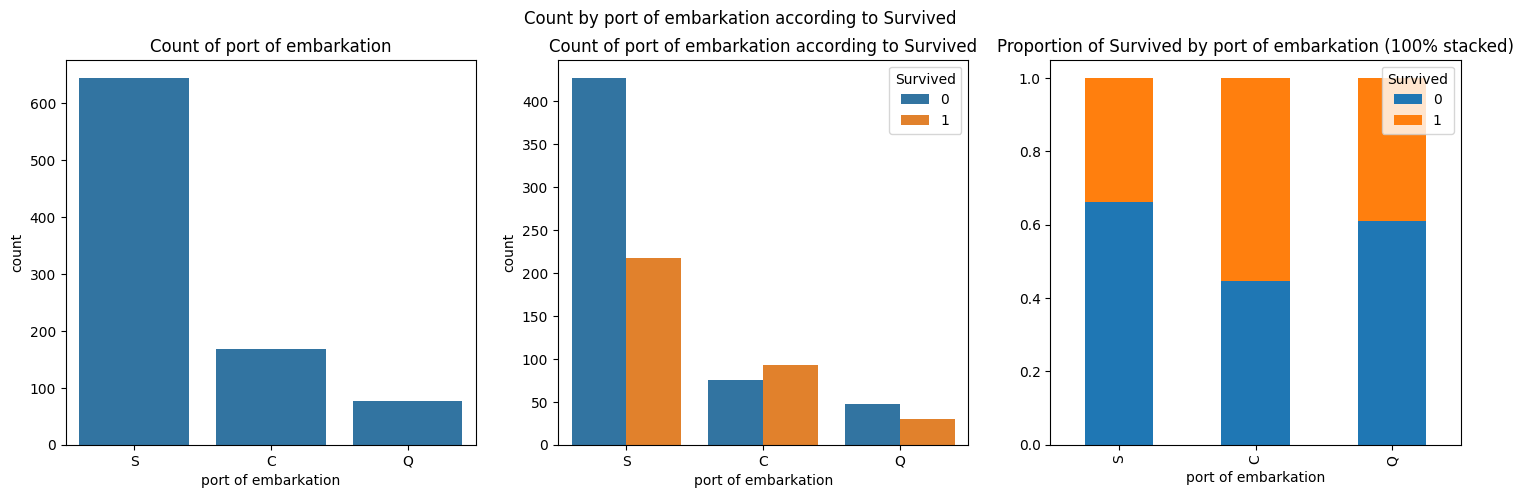

class


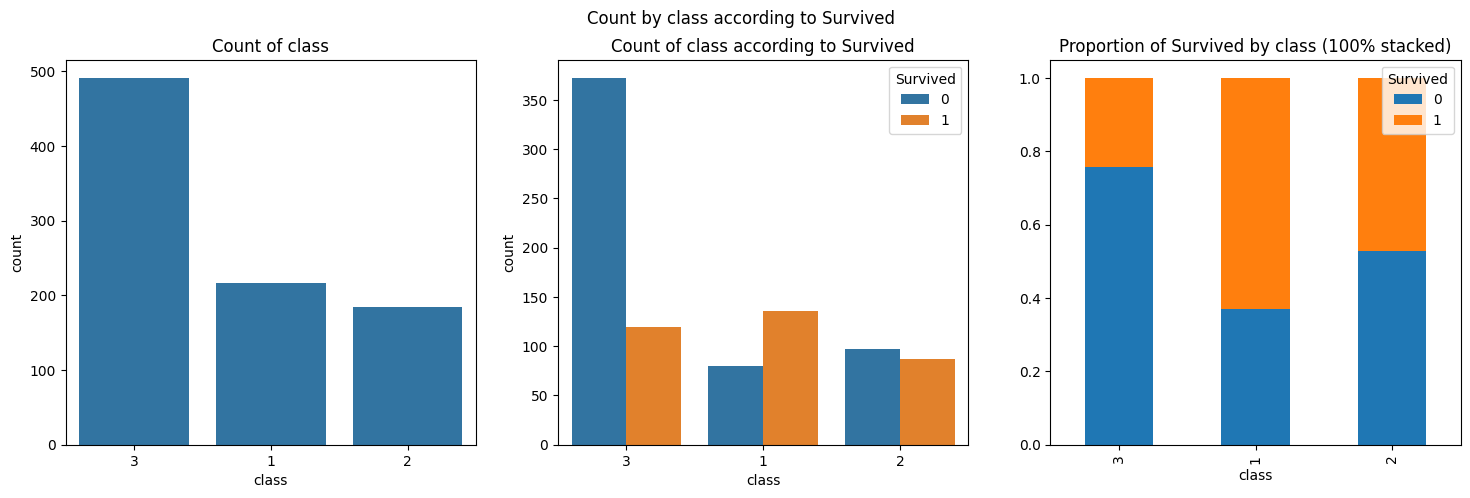

sex


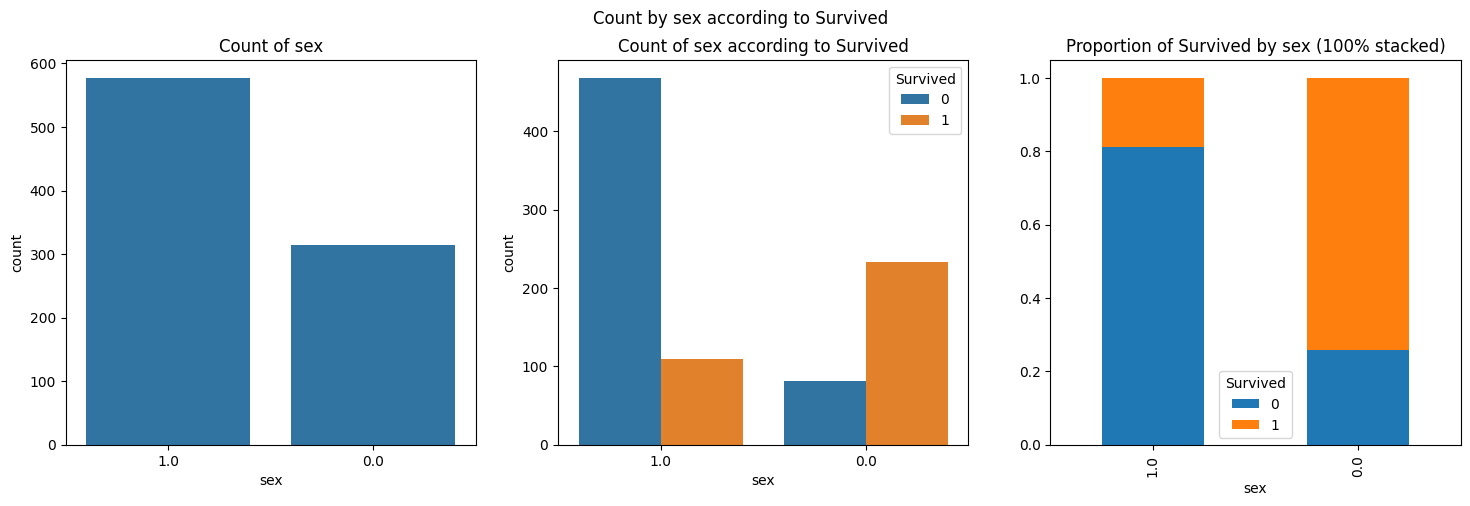

In [34]:
cat_variables = ['Embarked','Pclass','Sex']
cat_var_name = ['port of embarkation', 'class','sex']
for col, col_name in zip(cat_variables, cat_var_name):
    compare_cat_vs_target(df_train, col,"Survived",col_name)

- There is a clear difference in survival rates depending on class and gender.

Parch


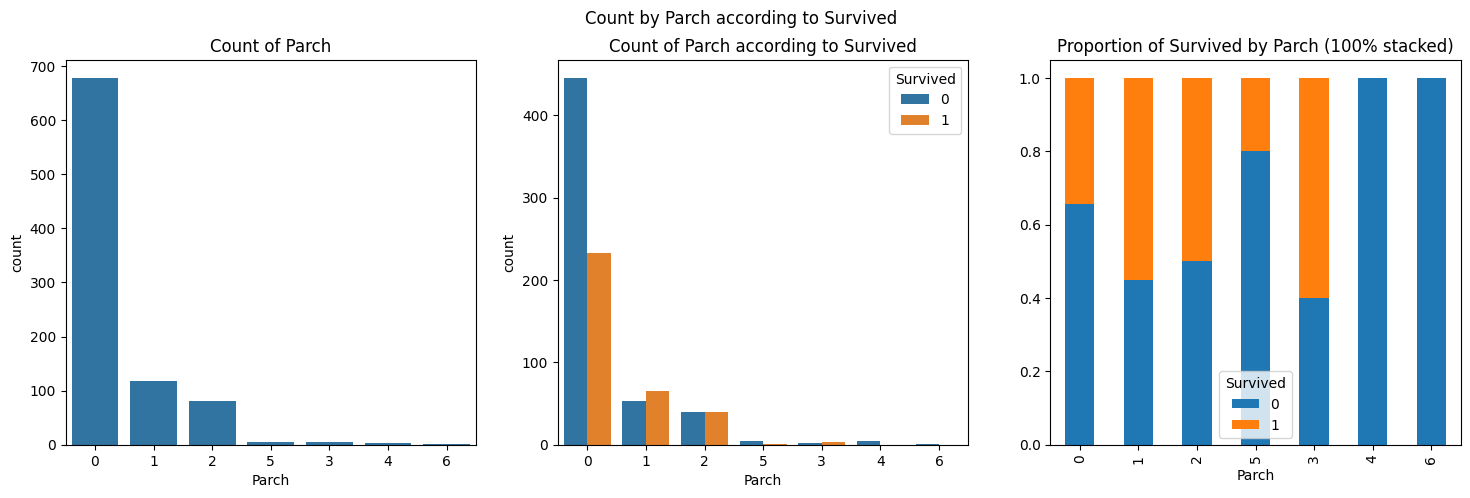

SibSp


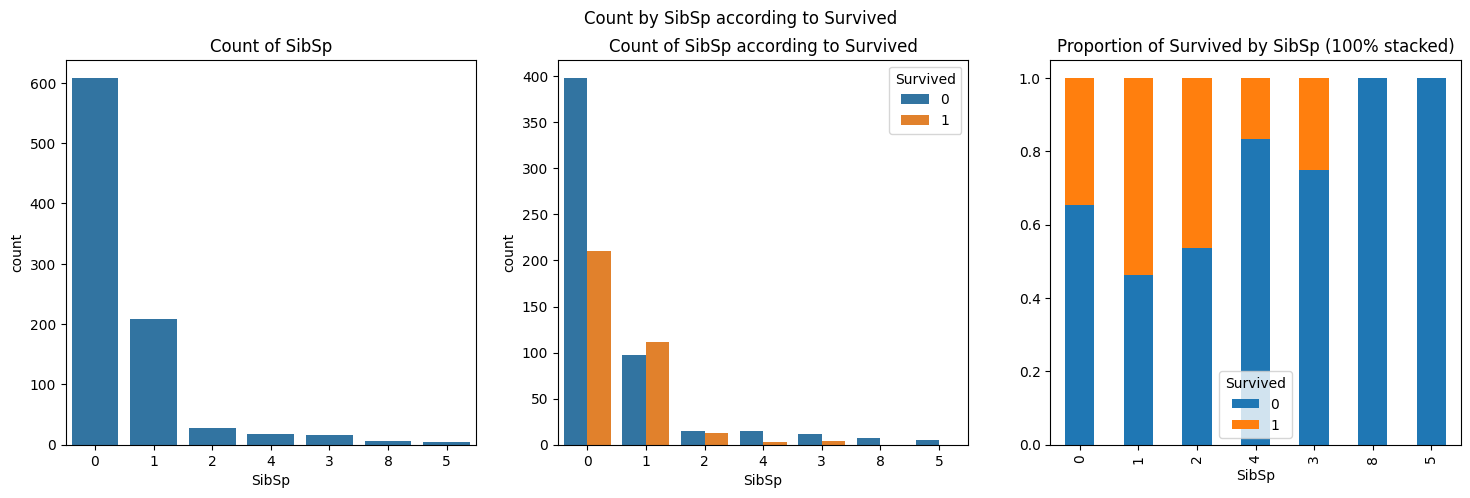

In [35]:
for col in discret_num_cols:
    compare_cat_vs_target(df_train, col,"Survived")

- It would appear that those who have few or no relatives are more likely to survive, but this is difficult to determine just from a graph.

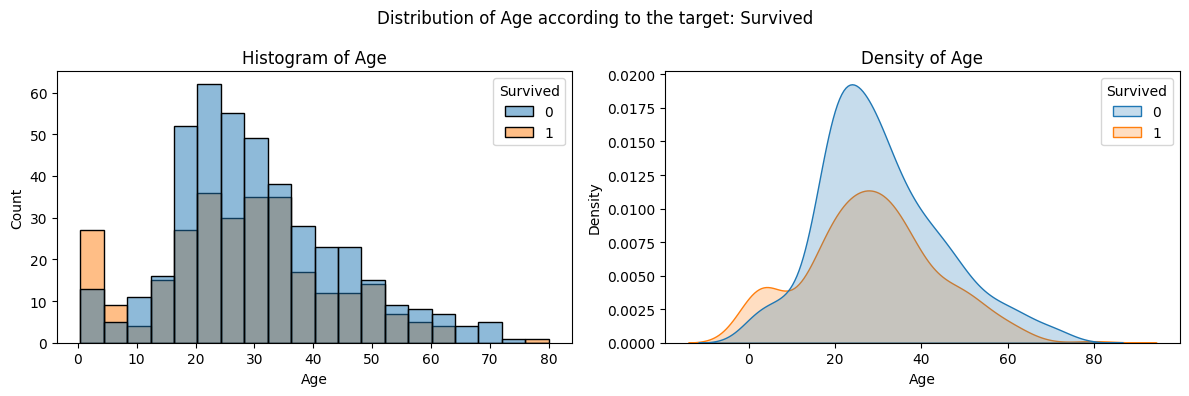

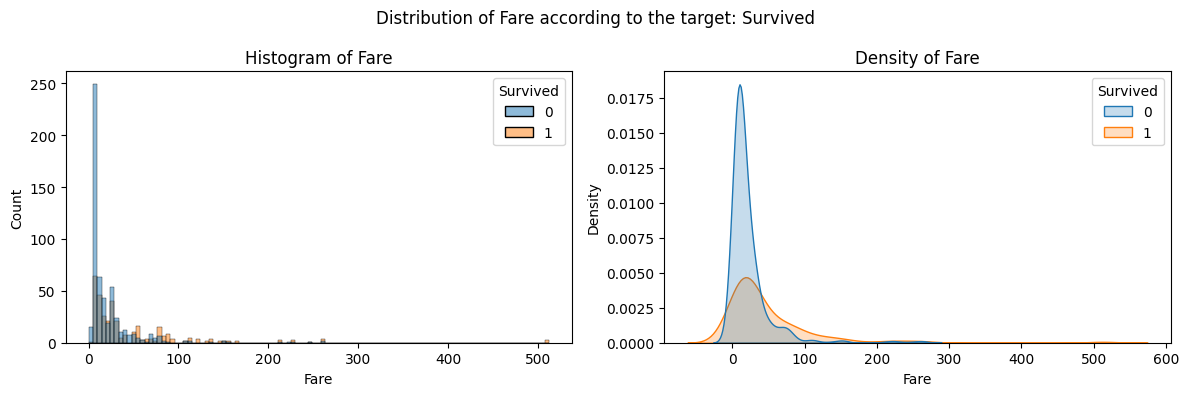

In [36]:
# Visualisation of the continuous numerical variable accoriding to the target
for col in continous_num_cols:
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
    sns.histplot(df_train, x=col, hue='Survived', ax=axes[0])
    sns.kdeplot(df_train, x=col, hue='Survived',fill=True, ax=axes[1])
    axes[0].set_title(f"Histogram of {col}")
    axes[1].set_title(f"Density of {col}")
    plt.suptitle(f"Distribution of {col} according to the target: Survived")
    plt.tight_layout()
    plt.show()

In [37]:
## Display distribution according to the target 
for col in continous_num_cols: 
    print(f"Descriptive statistics distribution of the {col} according to the target:Survived")
    display(df_train.groupby(["Survived"])[col].describe(percentiles=[0.05,0.25,0.5,0.75,0.95]).round(1))

Descriptive statistics distribution of the Age according to the target:Survived


,count,mean,std,min,5%,25%,50%,75%,95%,max
Survived,,,,,,,,,,
0,424.0,30.6,14.2,1.0,9.0,21.0,28.0,39.0,58.0,74.0
1,290.0,28.3,15.0,0.4,2.5,19.0,28.0,36.0,54.0,80.0


Descriptive statistics distribution of the Fare according to the target:Survived


,count,mean,std,min,5%,25%,50%,75%,95%,max
Survived,,,,,,,,,,
0,549.0,22.1,31.4,0.0,7.0,7.9,10.5,26.0,72.5,263.0
1,342.0,48.4,66.6,0.0,7.8,12.5,26.0,57.0,153.4,512.3


- Even though the median age of the two groups (deceased and survivors) is the same (28 years old), their Q1 differs by 3 years (21 years old for non-survivors vs. 19 years old for survivors). This confirms the shape of the curves for young people. The percentage of young people is higher among survivors.
- In addition, we see that you are more likely to survive if you paid more than £50 for your ticket. And that most of the people who did not survive paid less than £11 for their ticket.

**Visualization conclusion:**  

These initial visualizations based on the target show that: 
- there is a greater chance of survival among women, those in first class, as well as those under the age of 19 and those who paid for an expensive ticket.
- So, It would seem that women, children, and the wealthy were saved.

However, this remains to be confirmed with correlation and independence tests.
Furthermore, it could be that “Fare” is correlated with “PClass.”

### Test correlation

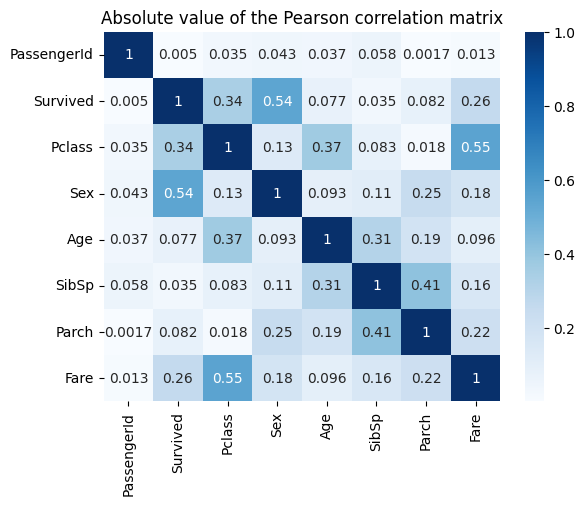

In [38]:
corr_matrix = df_train.select_dtypes(include='number').corr()
corr_matrix.round(3)
sns.heatmap(abs(corr_matrix), cmap="Blues", annot=True)
plt.title("Absolute value of the Pearson correlation matrix")
plt.show()

In [39]:
corr_matrix['Survived'].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Sex           -0.543351
Name: Survived, dtype: float64

- The highest correlation appears to be with 'Sex', 'Pclass' and 'Fare'. However, this correlation is only indicative, as the target is not really a numerical variable, nor is 'Sex' and ‘Pclass’, which are categorical variables encoded as integers.
- And PClass and Fare a moderatly correlated.

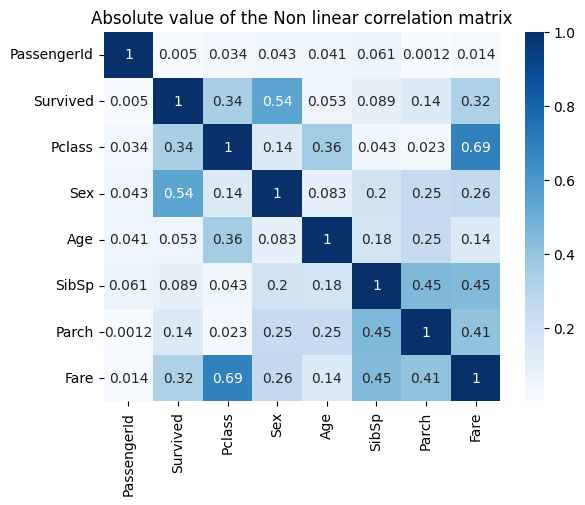

In [40]:
# Non Linear correlation 
corr_matrix = df_train.select_dtypes(include='number').corr('spearman')
corr_matrix.round(3)
sns.heatmap(abs(corr_matrix), cmap="Blues", annot=True)
plt.title("Absolute value of the Non linear correlation matrix")
plt.show()

- Here, the highest correlation is between “PClass” and “Fare” with r = 0.69. We need to be cautious about multicollinearity if we use a linear model. But since the correlation is still below 0.70, we will not perform a VIF test for now. 

- The correlation with the target does not change much; the variable most correlated with the target remains “Gender,” with a moderate/low correlation of r = 0.54.

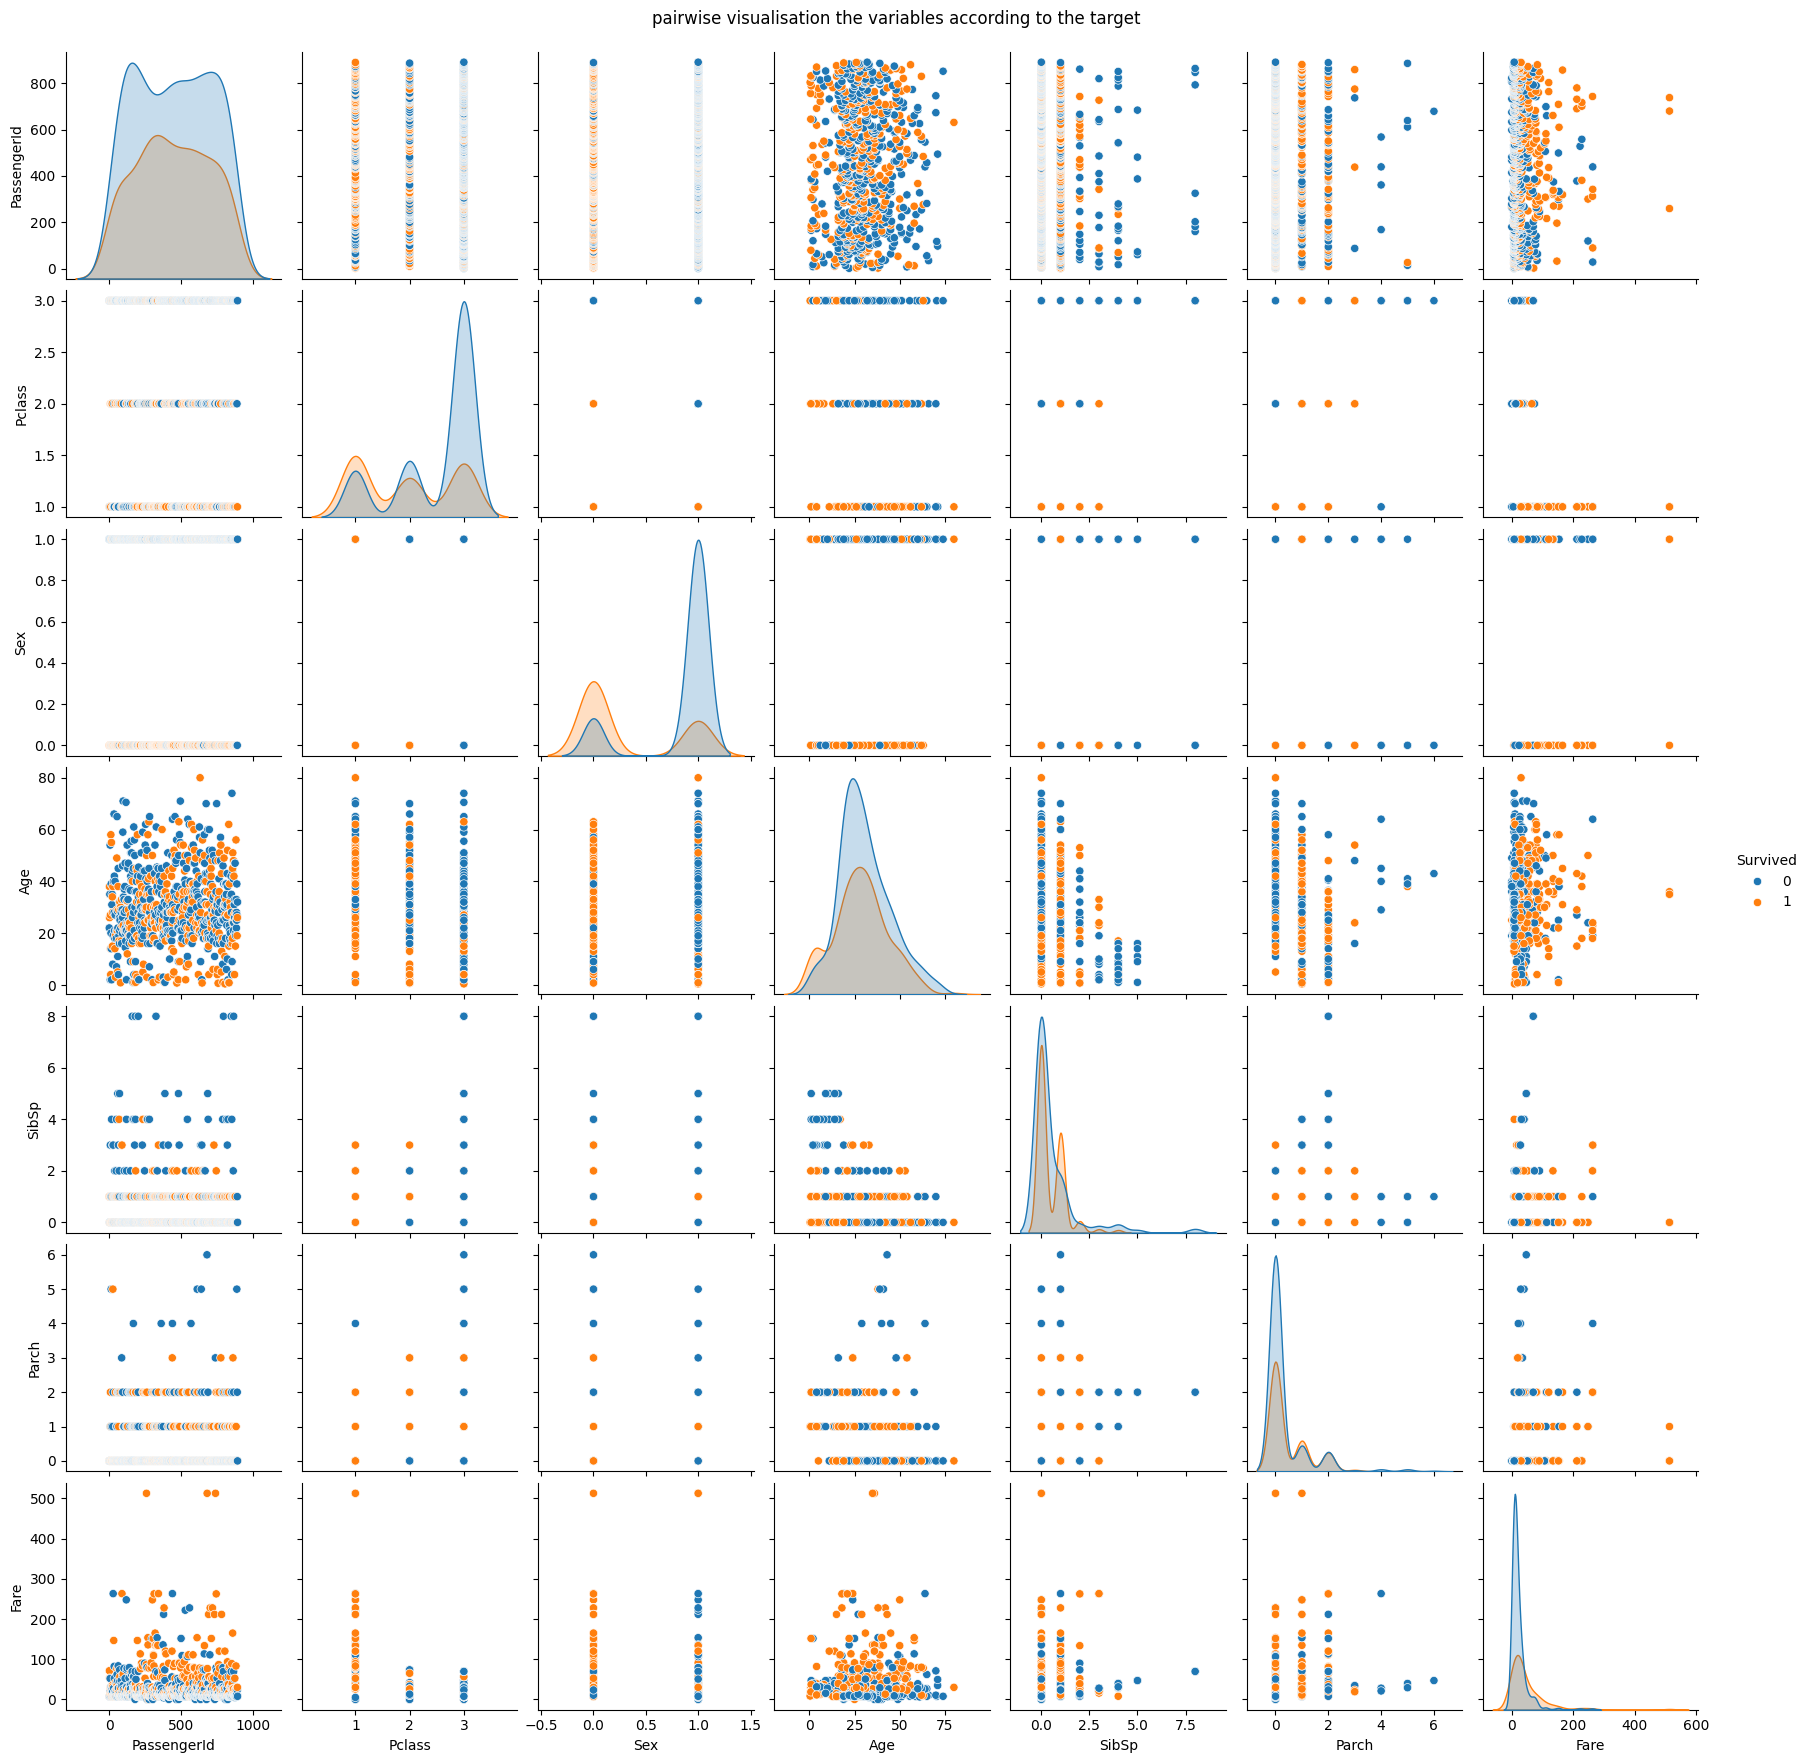

In [41]:
g = sns.pairplot(df_train, hue="Survived")
g.fig.suptitle("pairwise visualisation the variables according to the target", y=1.01)
plt.show()

**Do we have a real correlation between 'Sex','Pclass' and 'Embarked' variables with the target ?**
- We will perform chi2 test to establish the variables are independant ou dependant 

In [42]:
from scipy.stats import chi2_contingency
# Contiengency table
contingency = pd.crosstab(df_train['Sex'], df_train['Survived'])
display(contingency)

chi2, p, dof, expected = chi2_contingency(contingency)

print(f"Chi²: {chi2:.2f}, p-value: {p:.4f}")
if p < 0.05:
    print("On rejette H₀ : les variables sont dépendantes")
else:
    print("On ne rejette pas H₀ : pas de lien détecté")

Survived,0,1
Sex,,
0.0,81,233
1.0,468,109


Chi²: 260.72, p-value: 0.0000
On rejette H₀ : les variables sont dépendantes


In [43]:
for col in cat_variables: 
    print(f"\nChi 2 test between {col} and the target: Survived --------------- \n")
    contingency = pd.crosstab(df_train[col], df_train['Survived'])
    
    chi2, p, dof, expected = chi2_contingency(contingency)
    
    print(f"Chi²: {chi2:.2f}, p-value: {p:.4f}")
    if p < 0.05:
        print("We Reject H₀ : the variables are dependent")
    else:
        print("We do not reject H₀ : no relation found")


Chi 2 test between Embarked and the target: Survived --------------- 

Chi²: 26.49, p-value: 0.0000
We Reject H₀ : the variables are dependent

Chi 2 test between Pclass and the target: Survived --------------- 

Chi²: 102.89, p-value: 0.0000
We Reject H₀ : the variables are dependent

Chi 2 test between Sex and the target: Survived --------------- 

Chi²: 260.72, p-value: 0.0000
We Reject H₀ : the variables are dependent


- As the visualizations suggested, survivor status depends on gender, class, and port of embarkation.

**Let's find if the survival class is dependent or not to 'Age' or 'Fare' ?**  
- For that, we will perform t-test if the distribution are normal, and Mann-Whitney and Welch if not

For that we will do a t-test if the variables are normal

In [44]:
## First let's test the normality
def test_stats_normality(df, var , alpha =0.05):
    # Variables, constantes
    data = df[var].dropna()
    
    mu = df[var].mean()
    sigma= df[var].std()

    # Test normality
    ks_stat, ks_pvalue = kstest(data, 'norm', (mu, sigma))
    shapiro_stat, shapiro_pvalue = shapiro(data)

    if ks_pvalue > alpha:
        ks_interpretation = "fail to reject H0"
        ks_conclusion = f"- As the p_value > {alpha} for Kolmogorov-Smirnov test, so we do not reject H0 and assume that {var} distribution IS normal"
    else:
        ks_interpretation = "reject H0"
        ks_conclusion = f"- As the p_value < {alpha} for Kolmogorov-Smirnov test, so reject H0 and assume that {var} distribution IS NOT normal"

    if shapiro_pvalue > alpha:
        shapiro_interpretation = "fail to reject H0"
        shapiro_conclusion = "p_value > 0.05, we do not reject H0"
    else:
        shapiro_interpretation = "reject H0"
        shapiro_conclusion = "p_value < 0.05, we reject H0"

    dict_result = {'Test': ['Kolmogorov-Smirnov','Shapiro'],
                   'statistic': [ks_stat, shapiro_stat],
                   'p_value': [ks_pvalue, shapiro_pvalue],
                  'interpretation': [ks_interpretation, shapiro_interpretation]}
    
    print("\n **Tests d'adéquation à la loi normale - Normality Tests**")
    print(f"alpha = {alpha}")
    
    result = pd.DataFrame.from_dict(dict_result)
    conclusion = f"\nConclusion:\n {ks_conclusion}"
    return (result, conclusion)

In [45]:
## Test normality of 'age' and 
for col in ['Age','Fare']:
    result, conclusion = test_stats_normality(df_train, col)
    print(result, conclusion)


 **Tests d'adéquation à la loi normale - Normality Tests**
alpha = 0.05
                 Test  statistic       p_value interpretation
0  Kolmogorov-Smirnov   0.064567  4.958147e-03      reject H0
1             Shapiro   0.981458  7.337349e-08      reject H0 
Conclusion:
 - As the p_value < 0.05 for Kolmogorov-Smirnov test, so reject H0 and assume that Age distribution IS NOT normal

 **Tests d'adéquation à la loi normale - Normality Tests**
alpha = 0.05
                 Test  statistic       p_value interpretation
0  Kolmogorov-Smirnov   0.281848  4.179693e-63      reject H0
1             Shapiro   0.521891  1.084044e-43      reject H0 
Conclusion:
 - As the p_value < 0.05 for Kolmogorov-Smirnov test, so reject H0 and assume that Fare distribution IS NOT normal


- The variables “Age” and “Rate” are not normal, as expected from the curves, and therefore we cannot perform a t-test.
- Instead, we will perform Welch's and Wilcoxon-Mann-Whitney tests.

In [46]:
alpha = 0.05
for col in ['Age','Fare']: 
    print(f"\n **Test the dependance/independance between the {col.upper()} and 'Survived'**")
    df = df_train[['Survived',col]].dropna(subset=col)

    g1 = df[df['Survived'] == 0][col]
    g2 = df[df['Survived'] == 1][col]
    
    # Variance equality test
    print("\n Levene's Test")
    levene_stat, levene_p_value = levene(g1, g2)
    if levene_p_value < alpha: 
        print(" - The variances are not equal")
    else:
        print(" - The variance are equal")

    print("\n Independance tests: Welch & Wilcoxon-Mann-Whitney")
    
    # Welch test 
    welch_stat, welch_p_value = ttest_ind(g1, g2, equal_var=False)
    if welch_p_value < alpha: 
        welch_interpretation = "reject H0"
        welch_conclusion = f" - The p_value < {alpha}, we rejet the null hypothesis, and the conclude that there is a significant difference"
    else: 
        welch_interpretation = "fail to reject H0"
        welch_conclusion = f" - The p_value: {welch_p_value:.4f} > {alpha}, we fail to rejet the null hypothesis, and the conclude that there is no significant difference"

    # Wilcoxon-Mann-Whitney
    mwu_stat, mwu_p_value =  mannwhitneyu(g1, g2, alternative='two-sided')
    if mwu_p_value < alpha: 
        mwu_interpretation = "reject H0"
        mwu_conclusion = f" - The p_value < {alpha}, we rejet the nullhypothesis, and the conclude that there is a significant difference between each '{col}' groups"
    else: 
        mwu_interpretation = "fail to reject H0"
        mwu_conclusion = f" - The p_value: {mwu_p_value:.4f} > {alpha}, we fail to rejet the nullhypothesis, and the conclude that there is no significant difference between each '{col}' groups"

    dict_result = {'Test': ['Welch','Mann-Whitney'],
                   'statistic': [welch_stat, mwu_stat],
                   'p_value': [welch_p_value, mwu_p_value],
                  'interpretation': [welch_interpretation, mwu_interpretation]}
    result = pd.DataFrame.from_dict(dict_result)
    print(result)


 **Test the dependance/independance between the AGE and 'Survived'**

 Levene's Test
 - The variance are equal

 Independance tests: Welch & Wilcoxon-Mann-Whitney
           Test    statistic   p_value     interpretation
0         Welch      2.04603  0.041190          reject H0
1  Mann-Whitney  65278.00000  0.160493  fail to reject H0

 **Test the dependance/independance between the FARE and 'Survived'**

 Levene's Test
 - The variances are not equal

 Independance tests: Welch & Wilcoxon-Mann-Whitney
           Test     statistic       p_value interpretation
0         Welch     -6.839099  2.699332e-11      reject H0
1  Mann-Whitney  57806.500000  4.553477e-22      reject H0


- Survivor status depends on fare price, as shown in the graphs.
- Regarding ‘age’, the two tests performed do not agree, so I choose to say that there is no clear relationship between age and survivor status. However, I intend to keep this variable as an input.

**Conclusion of correlation and dependency study**  
- The correlation study and statistical independence tests allow us to move forward with greater confidence on the rest of the project. Even though we have few input variables, most of them are dependent on the target. This is a good sign. 
- Furthermore, the other variables are not correlated with each other, which is good. 

# Preprocessing & Transformation pipeline
In this section, we will perform the necessary transformations before applying an ML model. In addition, these transformations will be integrated into a pipeline to automate the process.

In [47]:
# Transformed each colum 
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    float64
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(3), int64(5), object(4)
memory usage: 83.7+ KB


In [48]:
cat_variables 

['Embarked', 'Pclass', 'Sex']

In [49]:
num_discret_variables = ['Parch', 'SibSp']
num_continuous_variables =  ['Age','Fare']
cat_variables = ['Embarked','Pclass','Sex']

In [50]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

num_discret_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("standardize", StandardScaler()),
])

log_pipeline = make_pipeline( 
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log1p, inverse_func= np.expm1, feature_names_out ="one-to-one"),
    StandardScaler()
)
    
num_continuous_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

#less_freq_cat = [X_train[col].value_counts().index[-1] for col in cat_variables]
cat_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("cat_encode", OneHotEncoder(handle_unknown="ignore", drop='first'))
])


preprocessing_pipeline = ColumnTransformer([
    ("discret",num_discret_pipeline, num_discret_variables),
    ("log", log_pipeline, ["Fare"]),
    ("num",num_continuous_pipeline, ["Age"]),
    ("cat", cat_pipeline, cat_variables)
])



In [51]:
preprocessing_pipeline

ColumnTransformer(transformers=[('discret',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('standardize',
                                                  StandardScaler())]),
                                 ['Parch', 'SibSp']),
                                ('log',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log1p'>,
                                                                      inverse_func=<ufunc 'expm1'>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Fare']),
                                ('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardize',
                                                  StandardScaler())]),
                                 ['Age']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('cat_encode',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['Embarked', 'Pclass', 'Sex'])])

In [52]:
df_train_prepared = preprocessing_pipeline.fit_transform(df_train)
print(df_train_prepared.shape)
print(preprocessing_pipeline.get_feature_names_out())
df_train_prepared

(891, 9)
['discret__Parch' 'discret__SibSp' 'log__Fare' 'num__Age'
 'cat__Embarked_Q' 'cat__Embarked_S' 'cat__Pclass_2' 'cat__Pclass_3'
 'cat__Sex_1.0']


array([[-0.47367361,  0.43279337, -0.87974057, ...,  0.        ,
         1.        ,  1.        ],
       [-0.47367361,  0.43279337,  1.36121993, ...,  0.        ,
         0.        ,  0.        ],
       [-0.47367361, -0.4745452 , -0.79853997, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 2.00893337,  0.43279337,  0.24200664, ...,  0.        ,
         1.        ,  0.        ],
       [-0.47367361, -0.4745452 ,  0.48708246, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47367361, -0.4745452 , -0.81898658, ...,  0.        ,
         1.        ,  1.        ]], shape=(891, 9))

In [53]:
X_train_prepared = pd.DataFrame(df_train_prepared, columns=preprocessing_pipeline.get_feature_names_out())
X_train_prepared

,discret__Parch,discret__SibSp,log__Fare,num__Age,cat__Embarked_Q,cat__Embarked_S,cat__Pclass_2,cat__Pclass_3,cat__Sex_1.0
0,-0.473674,0.432793,-0.879741,-0.565736,0.0,1.0,0.0,1.0,1.0
1,-0.473674,0.432793,1.361220,0.663861,0.0,0.0,0.0,0.0,0.0
2,-0.473674,-0.474545,-0.798540,-0.258337,0.0,1.0,0.0,1.0,0.0
3,-0.473674,0.432793,1.062038,0.433312,0.0,1.0,0.0,0.0,0.0
4,-0.473674,-0.474545,-0.784179,0.433312,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
886,-0.473674,-0.474545,-0.333698,-0.181487,0.0,1.0,1.0,0.0,1.0
887,-0.473674,-0.474545,0.487082,-0.796286,0.0,1.0,0.0,0.0,0.0
888,2.008933,0.432793,0.242007,-0.104637,0.0,1.0,0.0,1.0,0.0
889,-0.473674,-0.474545,0.487082,-0.258337,0.0,0.0,0.0,0.0,1.0


In [54]:
## Comparer si les données sont plus "normal"
# original dataset 
train_set.describe().round(1)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.0,891.0,891.0,714.0,891.0,891.0,891.0
mean,446.0,0.4,2.3,29.7,0.5,0.4,32.2
std,257.4,0.5,0.8,14.5,1.1,0.8,49.7
min,1.0,0.0,1.0,0.4,0.0,0.0,0.0
25%,223.5,0.0,2.0,20.1,0.0,0.0,7.9
50%,446.0,0.0,3.0,28.0,0.0,0.0,14.5
75%,668.5,1.0,3.0,38.0,1.0,0.0,31.0
max,891.0,1.0,3.0,80.0,8.0,6.0,512.3


In [55]:
# transformed data 
X_train_prepared.describe().round(1)

,discret__Parch,discret__SibSp,log__Fare,num__Age,cat__Embarked_Q,cat__Embarked_S,cat__Pclass_2,cat__Pclass_3,cat__Sex_1.0
count,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0
mean,0.0,0.0,-0.0,0.0,0.1,0.7,0.2,0.6,0.6
std,1.0,1.0,1.0,1.0,0.3,0.4,0.4,0.5,0.5
min,-0.5,-0.5,-3.1,-2.2,0.0,0.0,0.0,0.0,0.0
25%,-0.5,-0.5,-0.8,-0.6,0.0,0.0,0.0,0.0,0.0
50%,-0.5,-0.5,-0.2,-0.1,0.0,1.0,0.0,1.0,1.0
75%,-0.5,0.4,0.5,0.4,0.0,1.0,0.0,1.0,1.0
max,7.0,6.8,3.4,3.9,1.0,1.0,1.0,1.0,1.0


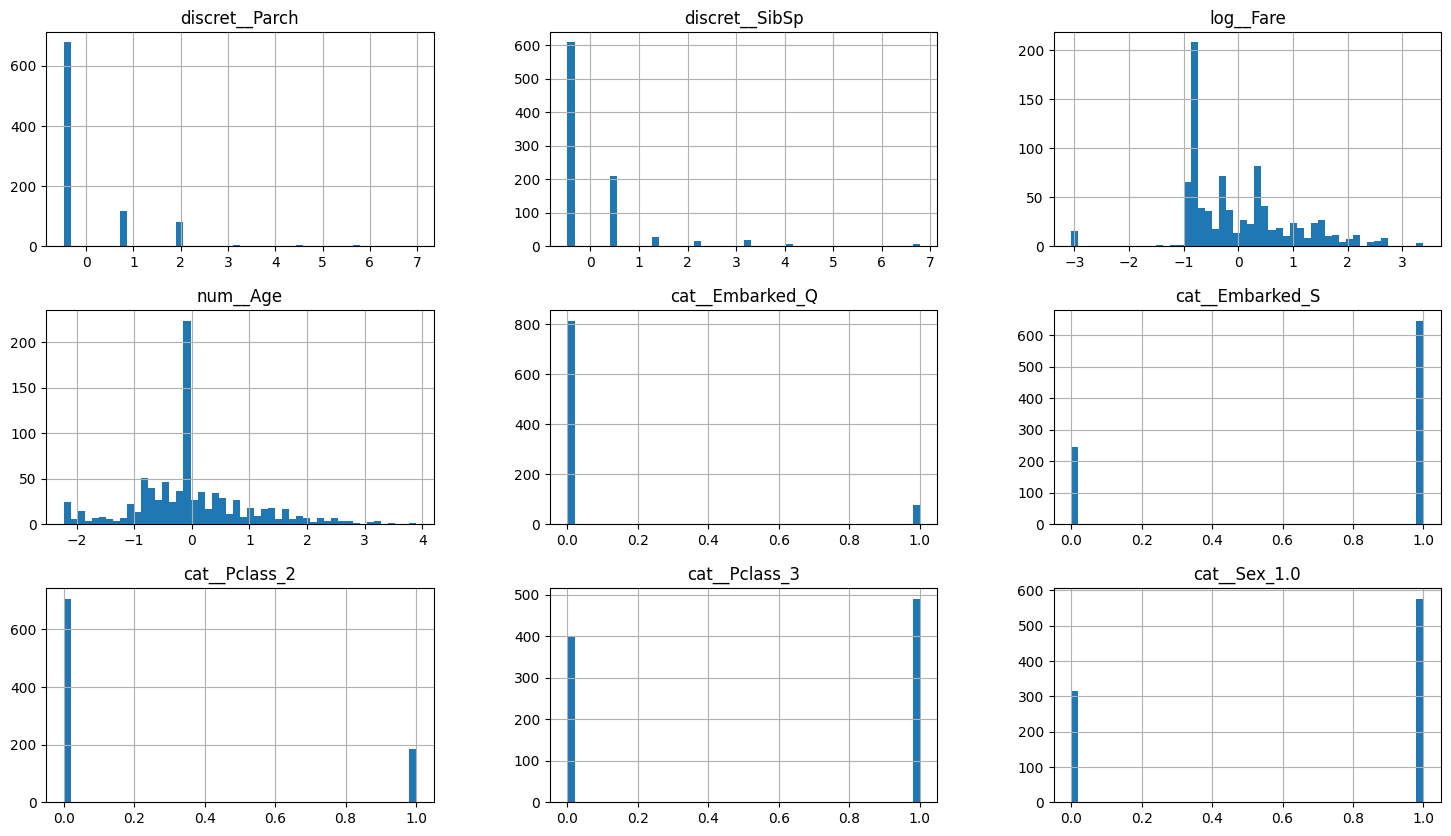

In [56]:
X_train_prepared.hist(bins=50, figsize=(18,10))
plt.show()

# Modelisation

In [57]:
# Split the data
X_train, y_train = train_set.drop(columns='Survived'), train_set['Survived']
X_test, y_test = test_set, gender_submission['Survived']

In [58]:
## Test logistic regression 
log_reg = LogisticRegression()

log_reg_pipeline = make_pipeline(preprocessing_pipeline, log_reg)

In [59]:
log_reg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('discret',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['Parch', 'SibSp']),
                                                 ('log',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       f...
                                                                   StandardScaler())]),
                                                  ['Fare']),
                                                 ('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encode',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Embarked', 'Pclass',
                                                   'Sex'])])),
                ('logisticregression', LogisticRegression())])

In [60]:
y_pred_train = log_reg_pipeline.predict(X_train)

**Evaluate the model on the entire training set**

In [61]:
# Evaluate the model on the training data 
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train, y_pred_train)
cm

array([[471,  78],
       [103, 239]])

In [62]:
def evaluate_classifier(y_true, y_pred): 
    print("\n Evaluation of the model, trained on the entire train set")
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    print("Confusion matrix: \n", cm,"\n")
    print(f"- Accuracy: {round(accuracy,4)}")
    print(f"- Precision: {round(precision,4)}")
    print(f"- Recall: {round(recall,4)}")
    return cm, accuracy, precision, recall

In [63]:
cm, accuracy, precision, recall = evaluate_classifier(y_train, y_pred_train)


 Evaluation of the model, trained on the entire train set
Confusion matrix: 
 [[471  78]
 [103 239]] 

- Accuracy: 0.7969
- Precision: 0.7539
- Recall: 0.6988


- I have a high rate of False Negative

In [64]:
# Compute the scores
y_scores = log_reg_pipeline.decision_function(X_train) 

precision_recall_curve(y_train, y_pred_train)

(array([0.38383838, 0.75394322, 1.        ]),
 array([1.        , 0.69883041, 0.        ]),
 array([0, 1]))

In [65]:
## Display cm
cm

array([[471,  78],
       [103, 239]])

In [66]:
# Confusion matrix 
tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
print(tn, fp, fn, tp)

# True positive rate -> recall 
tpr = tp/(tp+fn)
print(f"True Postive Rate (recall) {tpr}")
print("\t", recall)

# False Positive Rate = 1 - True Negative Rate 
fpr = fp/(fp+tn)
print(f"False Postive Rate (recall) {fpr}")

# On peut vérifier ce calcul en utilisant roc_curve mais avec y_pred_train au lieu de y_scores 
fpr, tpr, thresholds = roc_curve(y_train, y_pred_train)
print(fpr, tpr, thresholds)

471 78 103 239
True Postive Rate (recall) 0.6988304093567251
	 0.6988304093567251
False Postive Rate (recall) 0.14207650273224043
[0.        0.1420765 1.       ] [0.         0.69883041 1.        ] [inf  1.  0.]


Now than we have a idea of the logistic regression model on the entire training set, we will compare different models with cross validation

## Benchmark

1. **First we will create some function to automatize the procress**

In [67]:
def compute_classifier_metric_with_cv(estimator, X, y, cv):
    """
    Compute accuracy, precision, recall for each fold with cross_val_score
    --------
    Returns: A dictionary of the average scores obtained on each fold, for each metric (precision, accuracy, recall).
    """
    cv_scores = {}
    for metric in ['accuracy', 'precision', 'recall']: 
        cv_score = cross_val_score(estimator, X, y, cv=cv, scoring=metric)
        cv_mean_score = np.mean(cv_score).item()
        cv_scores[metric] = cv_mean_score
        print(f"{metric.capitalize()} score from cv: {cv_score.round(4)}\t| mean cv {metric}: {round(cv_mean_score,3)}")

    return cv_scores
    

In [68]:
def plot_roc_curve(y_true, y_scores): 
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate: 1 - specificity ")
    plt.ylabel("True Positive Rate: sensibility ")
    plt.title("ROC curve")
    plt.show()
    return fpr, tpr, thresholds

In [69]:
def compute_roc_auc_with_cv(estimator_name, estimator, X, y, cv, method = {"decision_function","predict_proba"}, precision_recall_curve = False): 
    """
    Get the score/proba of prediction "out-of-fold" set, then draw the ROC curve and compute auc score
    --------
    Return: fpr, tpr, thresholds, auc_score
    """
    # 4. Compute the ROC and AUC 
    # Calculate the score / or the proba 
    if method == "decision_function": 
        y_proba = cross_val_predict(estimator, X, y, cv=cv, method=method)
    else: 
        y_proba = cross_val_predict(estimator, X, y, cv=cv, method=method)[:,1]
    
    # Plot the curve 
    if precision_recall_curve: 
        precisions, recalls, thresholds = precision_recall_curve(y, y_proba)
        plot_precision_recall_curves(precisions, recalls, thresholds, name = estimator_name)
    
    # ROC & AUC 
    fpr, tpr, thresholds = plot_roc_curve(y, y_proba)
    auc_score  = roc_auc_score(y, y_proba)
    print(f"The AUC score is : {auc_score.round(4)}") 
    return fpr, tpr, thresholds, auc_score
    

In [70]:
def fit_predict_evaluate_classifier(estimator_name, estimator, X, y, cv, method = {"decision_function","predict_proba"}): 
    """
    - First, fit, predict and evaluate a classifier with cross validation from training set
    - Then, get the score/proba of prediction "out-of-fold" set, then draw the ROC curve and compute auc score
    --------
    Returns: {accuracy, precision, recall}, fpr, tpr, thresholds
    - A dictionary of the average scores obtained on each fold, for each metric (precision, accuracy, recall) + the auc_score 
    - And False Positive Rate, True Positive Rate, and thresholds obtained from sklearn.metrics.roc_curve
    """
    # 0. Model 
    print(f"{estimator_name.upper()} \n")
    
    # 1. Fit, Predict & Evaluate the model
    cv_scores = compute_classifier_metric_with_cv(estimator, X, y, cv)

    # 2. Compute the ROC and AUC
    fpr, tpr, thresholds, auc_score = compute_roc_auc_with_cv(estimator_name, estimator, X, y, cv, method = method)
    cv_scores['auc'] = auc_score.item()
    cv_scores['model'] = estimator_name
    
    return cv_scores, fpr, tpr, thresholds

2. Then we will split into folds. Here we make sure than we stratified the data as the "survived" class is not well balanced

In [71]:
# Create fold 
skf = StratifiedKFold(n_splits= 3, shuffle=True, random_state=42)

3. Let's compare models

LOGISTIC REGRESSION 

Accuracy score from cv: [0.8013 0.7912 0.8081]	| mean cv accuracy: 0.8
Precision score from cv: [0.7523 0.7766 0.7664]	| mean cv precision: 0.765
Recall score from cv: [0.7193 0.6404 0.7193]	| mean cv recall: 0.693


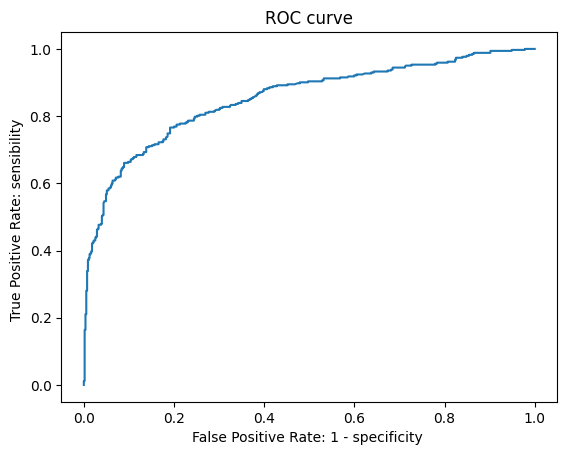

The AUC score is : 0.8527


In [72]:
## Model 1: Logistic Regression 
model = "Logistic Regression"
method = "decision_function"
lr_scores, fpr_lr, tpr_lr, thresholds_lr = fit_predict_evaluate_classifier(model, log_reg_pipeline, X_train, y_train, cv=skf, method=method)

DECISION TREE 

Accuracy score from cv: [0.8182 0.8316 0.8283]	| mean cv accuracy: 0.826
Precision score from cv: [0.8488 0.8478 0.8987]	| mean cv precision: 0.865
Recall score from cv: [0.6404 0.6842 0.6228]	| mean cv recall: 0.649


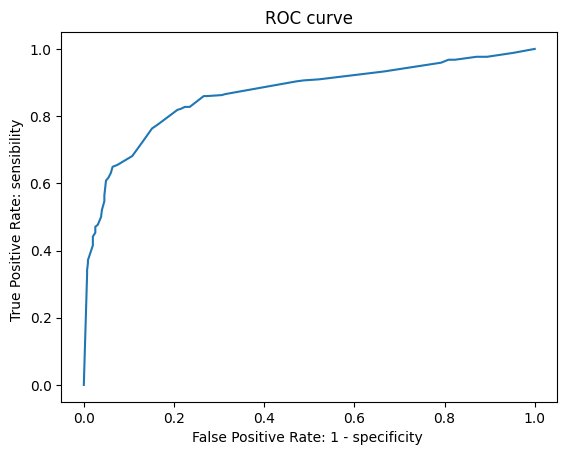

The AUC score is : 0.8658


In [73]:
## Model 2: Decision Tree
model = "Decision Tree"
method = "predict_proba"
# 1. Model & pipeline 
tree_clf = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_leaf=10)
tree_pipeline = make_pipeline(preprocessing_pipeline, tree_clf)

# 2. Fit, Predict & Evaluate the model 
tree_scores, fpr_tree, tpr_tree, thresholds_tree, = fit_predict_evaluate_classifier(model, tree_pipeline, X_train, y_train, cv=skf, method=method)

RANDOM FOREST 

Accuracy score from cv: [0.835  0.8081 0.835 ]	| mean cv accuracy: 0.826
Precision score from cv: [0.8736 0.8353 0.9012]	| mean cv precision: 0.87
Recall score from cv: [0.6667 0.6228 0.6404]	| mean cv recall: 0.643


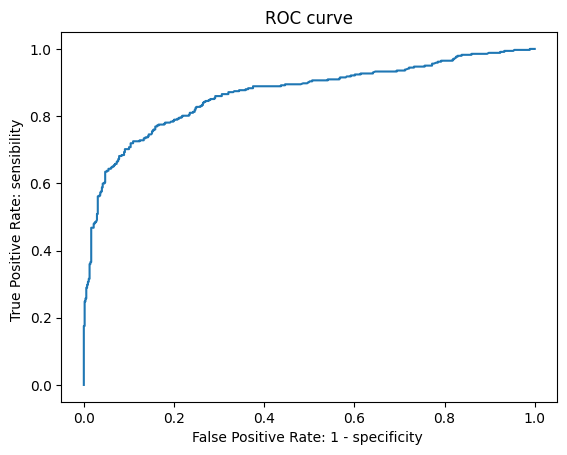

The AUC score is : 0.8672


In [74]:
## Model 3: Random Forest
model = "Random Forest"
method = "predict_proba"

# 1. Model & pipeline 
forest_clf = RandomForestClassifier(random_state=42, n_estimators= 100, max_depth=5, min_samples_leaf=1)
forest_pipeline = make_pipeline(preprocessing_pipeline, forest_clf)


# 2. Fit, Predict & Evaluate the model 
forest_scores, fpr_forest, tpr_forest, thresholds_forest = fit_predict_evaluate_classifier(model, forest_pipeline, X_train, y_train, cv=skf, method=method)


SVM 

Accuracy score from cv: [0.8249 0.8114 0.8316]	| mean cv accuracy: 0.823
Precision score from cv: [0.7925 0.8085 0.8077]	| mean cv precision: 0.803
Recall score from cv: [0.7368 0.6667 0.7368]	| mean cv recall: 0.713


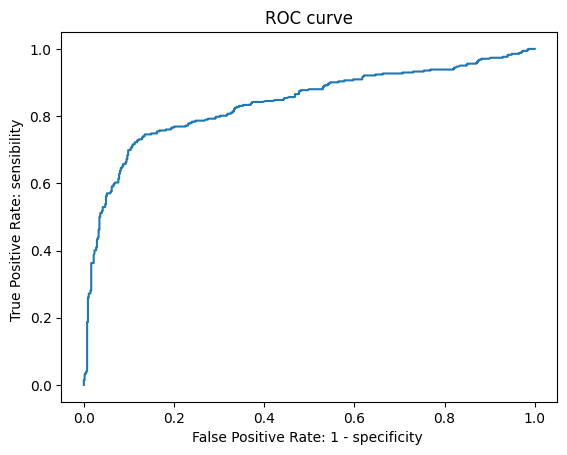

The AUC score is : 0.8385


In [75]:
## Model 4: SVM
from sklearn.svm import SVC
model = "SVM"
method = "decision_function"

# 1. Model & pipeline 
svm_clf = SVC(random_state=42, gamma="auto")
svc_pipeline = make_pipeline(preprocessing_pipeline, svm_clf)


# 2. Fit, Predict & Evaluate the model 
svc_scores, fpr_svc, tpr_svc, thresholds_svc = fit_predict_evaluate_classifier(model, svc_pipeline, X_train, y_train, cv=skf, method=method)


In [76]:
df_compare_perf = pd.DataFrame.from_dict([lr_scores, tree_scores, forest_scores, svc_scores]).set_index("model").reset_index()
df_compare_perf.round(3)

,model,accuracy,precision,recall,auc
0,Logistic Regression,0.800,0.765,0.693,0.853
1,Decision Tree,0.826,0.865,0.649,0.866
2,Random Forest,0.826,0.870,0.643,0.867
3,SVM,0.823,0.803,0.713,0.838


In [77]:
with open("reports/benchmark_performance","w") as f: 
    f.write(df_compare_perf.round(3).to_markdown(index=False))

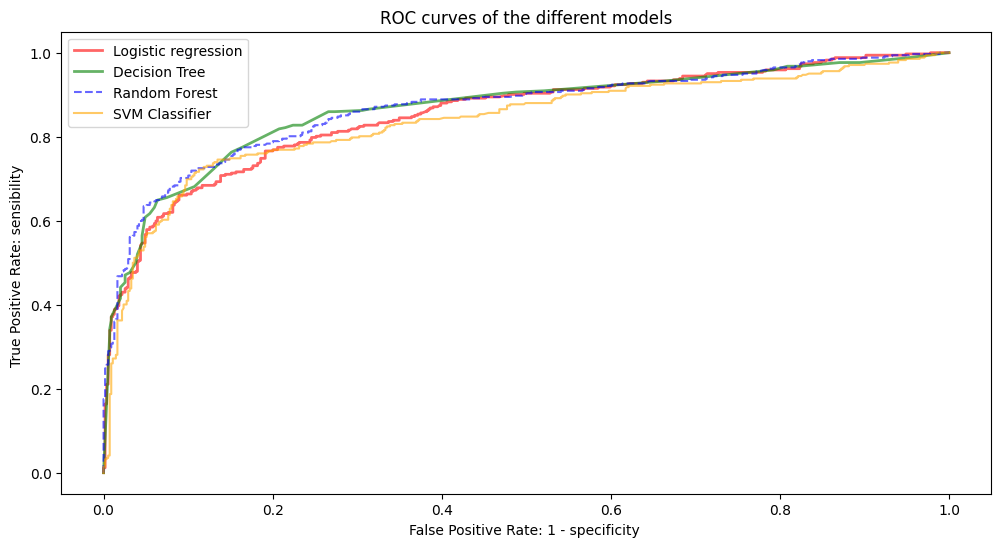

In [78]:
# Let's compare the differents models 
plt.figure(figsize=(12,6))
plt.plot(fpr_lr, tpr_lr, c='r', linestyle='-',  label='Logistic regression', alpha=0.6, linewidth=2.0)
plt.plot(fpr_tree, tpr_tree, c='green', linestyle='-',  label='Decision Tree', alpha=0.6, linewidth=2.0)
plt.plot(fpr_forest, tpr_forest, c='b', linestyle='--', label='Random Forest', alpha=0.6)
plt.plot(fpr_svc, tpr_svc, c='orange', linestyle='-', label='SVM Classifier', alpha=0.6)
plt.xlabel("False Positive Rate: 1 - specificity ")
plt.ylabel("True Positive Rate: sensibility ")
plt.legend()
plt.title("ROC curves of the different models")
plt.savefig("reports/roc_curves_of_benchmarked_models.jpg") # Save the grahs
plt.show()

- Decision Tree and Random Forest have the best accuracy (kaggle metrics) and the second best recalls, but as the Forest is more robust than the Tree we will keep it 
- And the SVM has the best recall (the metric of in interest for the survival context) we will keep it. 

## Fine Tuned a model

In [79]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Pipeline 
full_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('random_forest', RandomForestClassifier(random_state=42))
])
# Create parameters 
params = {
    'random_forest__max_depth': [2,5,10,20], 
    'random_forest__min_samples_leaf': [2,5,10],
    'random_forest__n_estimators': randint(2,50)

}

# 
rnd_search = RandomizedSearchCV( 
    full_pipeline, param_distributions= params, cv=skf,n_iter=10, scoring='recall')


In [80]:
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('discret',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('standardize',
                                                                                                StandardScaler())]),
                                                                               ['Parch',
                                                                                'SibSp']),
                                                                              ('log',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='...
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['Embarked',
                                                                                'Pclass',
                                                                                'Sex'])])),
                                             ('random_forest',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'random_forest__max_depth': [2, 5, 10,
                                                                     20],
                                        'random_forest__min_samples_leaf': [2,
                                                                            5,
                                                                            10],
                                        'random_forest__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7001ec20c880>},
                   scoring='recall')

In [81]:
# Show performances 
print(rnd_search.best_score_, "\n", rnd_search.best_params_)


0.7105263157894738 
 {'random_forest__max_depth': 20, 'random_forest__min_samples_leaf': 2, 'random_forest__n_estimators': 40}


**Fine Tune SVM**

In [82]:
from scipy.stats import randint

# Pipeline 
full_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('svm', SVC(random_state=42))
]) 
# Create parameters 
params = [ {
    'svm__C': randint(1,10), 
    'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
    'svm__gamma': ["scale", "auto"]
}]

# 
rnd_search = RandomizedSearchCV( 
    full_pipeline, param_distributions= params, cv=skf,n_iter=15, scoring='recall', random_state=365)

In [83]:
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('discret',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('standardize',
                                                                                                StandardScaler())]),
                                                                               ['Parch',
                                                                                'SibSp']),
                                                                              ('log',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='...
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['Embarked',
                                                                                'Pclass',
                                                                                'Sex'])])),
                                             ('svm', SVC(random_state=42))]),
                   n_iter=15,
                   param_distributions=[{'svm__C': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7001ec067400>,
                                         'svm__gamma': ['scale', 'auto'],
                                         'svm__kernel': ['linear', 'poly',
                                                         'rbf', 'sigmoid']}],
                   random_state=365, scoring='recall')

In [84]:
# Show performances 
print(rnd_search.best_score_, "\n", rnd_search.best_params_)
pd.DataFrame(rnd_search.cv_results_).sort_values(by='rank_test_score').head()

0.7602339181286549 
 {'svm__C': 2, 'svm__gamma': 'auto', 'svm__kernel': 'poly'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svm__C,param_svm__gamma,param_svm__kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
13,0.016979,0.000543,0.009082,0.000028,2,auto,poly,"{'svm__C': 2, 'svm__gamma': 'auto', 'svm__kern...",0.771930,0.736842,0.771930,0.760234,0.016541,1
0,0.020267,0.001959,0.009393,0.000513,3,scale,poly,"{'svm__C': 3, 'svm__gamma': 'scale', 'svm__ker...",0.754386,0.666667,0.745614,0.722222,0.039447,2
9,0.017844,0.000329,0.009958,0.000095,3,auto,rbf,"{'svm__C': 3, 'svm__gamma': 'auto', 'svm__kern...",0.728070,0.649123,0.710526,0.695906,0.033847,3
3,0.020270,0.000293,0.011893,0.000203,4,auto,rbf,"{'svm__C': 4, 'svm__gamma': 'auto', 'svm__kern...",0.728070,0.640351,0.692982,0.687135,0.036049,4
2,0.030299,0.008074,0.009863,0.000390,9,scale,linear,"{'svm__C': 9, 'svm__gamma': 'scale', 'svm__ker...",0.675439,0.622807,0.736842,0.678363,0.046601,5


- After a first tuning of the hyperparameters the SVM obtained better performances than Random Forest, we will do a second fine tuning only on the SVM. 
- Random Forest recalls: 0.64 -> 0.72
- SVM recalls: 0.71 -> 0.76

In [85]:
## Fine tunning 
# Create parameters 
fine_params = [ {
    'svm__C': np.linspace(1,5, num=33),
    'svm__kernel': ['poly', 'rbf'], 
    'svm__gamma': ["scale", "auto"]
}]

# 
rnd_search = RandomizedSearchCV( 
    full_pipeline, param_distributions= fine_params, cv=skf,n_iter=15, scoring='recall', random_state=365)
rnd_search.fit(X_train, y_train)
pd.DataFrame(rnd_search.cv_results_).sort_values(by='rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svm__kernel,param_svm__gamma,param_svm__C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,0.018140,0.000598,0.009880,0.000321,poly,auto,2.250,"{'svm__kernel': 'poly', 'svm__gamma': 'auto', ...",0.771930,0.736842,0.763158,0.757310,0.014909,1
8,0.016556,0.000666,0.008389,0.000019,poly,auto,4.125,"{'svm__kernel': 'poly', 'svm__gamma': 'auto', ...",0.780702,0.701754,0.754386,0.745614,0.032822,2
12,0.019545,0.001265,0.010052,0.000752,poly,scale,1.250,"{'svm__kernel': 'poly', 'svm__gamma': 'scale',...",0.771930,0.692982,0.754386,0.739766,0.033847,3


In [86]:
# Best Params 
print("Best params: ", rnd_search.best_params_)
# Best model
final_model = rnd_search.best_estimator_

Best params:  {'svm__kernel': 'poly', 'svm__gamma': 'auto', 'svm__C': np.float64(2.25)}


- With this fine tuned model the recall increase from 0.713 to 0.757, that is great !

## Evaluate the Final model

In [87]:
## Prediction on the X_test
# Predict 
y_pred =  final_model.predict(X_test)
# Calculer les scores 
y_scores = final_model.decision_function(X_test)

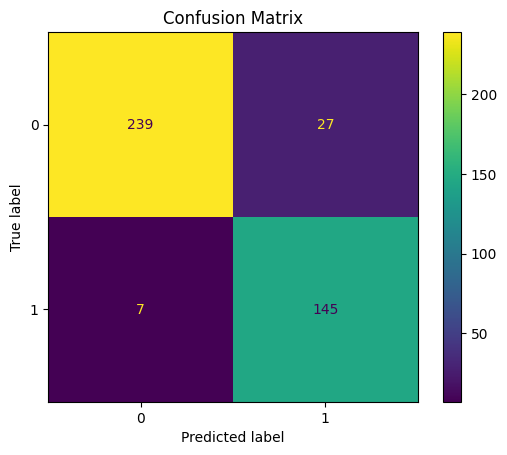


 Final Evaluation of the model on the entire test
- Accuracy: 0.919
- Precision: 0.843
- Recall: 0.954


In [88]:
## Evaluate the model 

# Confusion matrix 
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix")
plt.show()


# Metrics 
print("\n Final Evaluation of the model on the entire test")
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"- Accuracy: {round(accuracy,3)}")
print(f"- Precision: {round(precision,3)}")
print(f"- Recall: {round(recall,3)}")


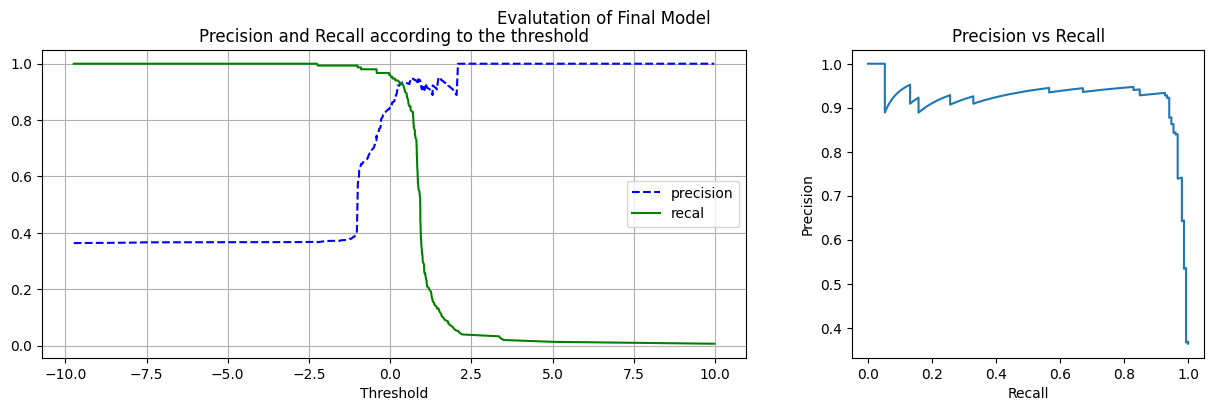

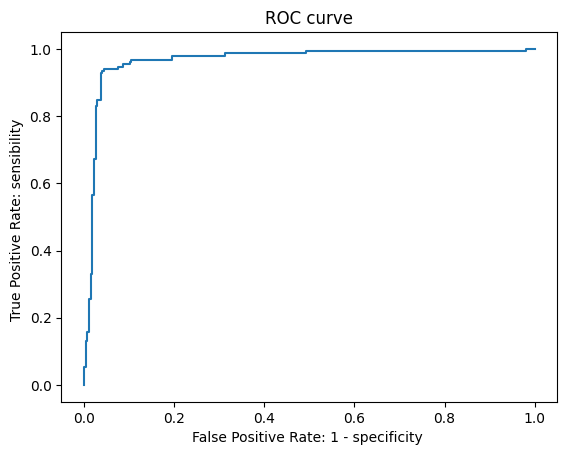

The AUC score is : 0.9654


In [89]:
## *** ROC Curve & AUC scores ***
## Compute the precison and the recall values for each thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

## Draw the curves
fig, axes = plt.subplots(1, 2, figsize=(15,4), gridspec_kw={'width_ratios': [2, 1]})
# Plot 
axes[0].plot(thresholds, precisions[:-1], "b--", label="precision")
axes[0].plot(thresholds, recalls[:-1], "g-", label="recal")
axes[0].grid()
axes[0].set_xlabel("Threshold")
axes[0].legend(loc="center right")
axes[0].set_title("Precision and Recall according to the threshold")

# Plot 2
axes[1].plot(recalls, precisions)
axes[1].set_title("Precision vs Recall")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")

plt.suptitle(f"Evalutation of Final Model")
plt.savefig("reports/Precision-and-recall-curves-of-the-final-model.jpg") # Save the grahs
plt.show()

## ROC & AUC 
fpr, tpr, thresholds = plot_roc_curve(y_test, y_scores)
auc_score  = roc_auc_score(y_test, y_scores)
print(f"The AUC score is : {auc_score.round(4)}") 

- The final model has a recall of 95% that is wonderful when we want to save as many people as possible
- Moreover, the better performances observed on the test set may be due to the variability as the sets are small < 1000 rows. 